In [49]:
# Generic libraries
import numpy as np
import pandas as pd
import scipy as sp
import tqdm
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.context('seaborn')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from collections import namedtuple
from tabulate import tabulate
from IPython.display import Latex
from IPython.display import HTML
from matplotlib import rc


In [51]:
# MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.coordinates.base import Timestep
from MDAnalysis.analysis import contacts
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import analysis_class
from MDAnalysis.lib.distances import capped_distance, self_capped_distance
from MDAnalysis.lib.distances import distance_array, self_distance_array
import MDAnalysis.analysis.hbonds as hb

from scipy.spatial.distance import squareform
from itertools import product
import inspect
import multiprocessing
import time
import os
import glob

In [3]:
## Import common data (e.g. pdb and psf files)
from pathlib import Path
simdir = Path('../data/00-external/')
PDB = simdir / '5Y36.pdb'
GRO = simdir / '5Y36_salted.gro'

# set paths for output
plotpath = "../plots/"
output_name = "ion_eq_"


In [4]:
## import full trajectory data 
trajdir = '../data/03-eqnpt/'
TRR = trajdir + 'cas9_npt.trr'
TRR2 = trajdir + 'cas9_npt2.trr'

## universe creation
u = mda.Universe(str(GRO), str(TRR), str(TRR2))
u_new = u.copy() # used as a reference in memory for mapping calculations
#ref0 = mda.Universe(str(GRO))
print(u.select_atoms("protein or name MG").n_atoms, 'nonwater/ions atoms')

# other info
box = u.dimensions
print('box dimensions:', box)
nframes = u.trajectory.n_frames
print(nframes, 'frames')
dt = u.trajectory.dt # ns per frame, equal to nstxout*0.002
time = np.arange(0, dt*nframes, dt)
t_ns = time / 1000
print(t_ns[-1], 'ns')


22526 nonwater/ions atoms
box dimensions: [183.99191  183.99191  183.99184   60.000008  60.000008  90.      ]
202 frames
10.05 ns


In [5]:
len(t_ns)

202

## Test of ions closeness to phosphates at the beginning of the equilibration vs at the end

In [6]:
# selections of the atomgroups for phosphates and sodium ions
phosphates = u.select_atoms('nucleic and name P')
sodium = u.select_atoms('name NA')
print(len(phosphates))
print(len(sodium))

import MDAnalysis.lib.distances as dist

178
549


In [7]:
max_cutoff = 8

pairs, distances = dist.capped_distance(phosphates.positions, sodium.positions,\
                                        max_cutoff, min_cutoff=None, box=box, return_distances=True)
for k, [i, j] in enumerate(pairs):
    coord1 = phosphates[i]
    coord2 = sodium[j]
    distance = distances[k]

print(pairs.shape)

(68, 2)


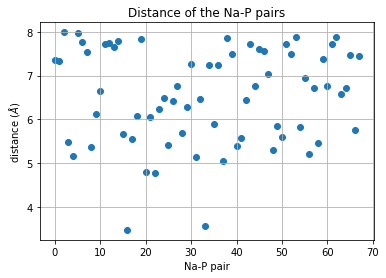

In [8]:
%matplotlib inline
plt.scatter(range(len(distances)), distances)
plt.xlabel('Na-P pair')
plt.ylabel('distance ($\AA$)')
plt.title(r'Distance of the Na-P pairs')
plt.grid()
plt.show()


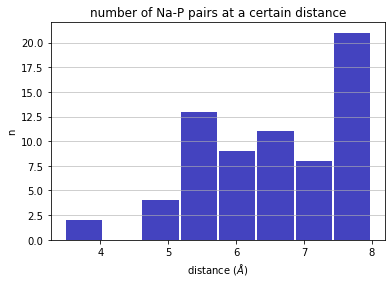

In [9]:
#plt.hist(distances)
n, bins, patches = plt.hist(x=distances, bins='auto', color='#0504aa', alpha=0.75, rwidth=0.95)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('distance ($\AA$)')
plt.ylabel('n')
plt.title(u'number of Na-P pairs at a certain distance')
plt.show()


In [10]:
phosphates_end = [u.select_atoms('nucleic and name P').positions for ts in u.trajectory[nframes-1:nframes]][0]
sodium_end = [u.select_atoms('name NA').positions for ts in u.trajectory[nframes-1:nframes]][0]

pairs_end, distances_end = dist.capped_distance(phosphates_end, sodium_end, max_cutoff,\
                                                min_cutoff=None, box=box, return_distances=True)
len(distances_end)

131

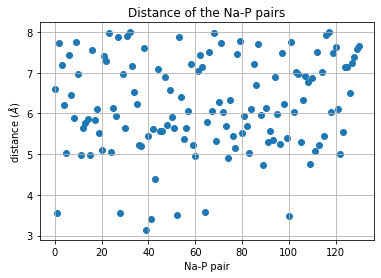

In [11]:
%matplotlib inline
plt.scatter(range(len(distances_end)), distances_end)
plt.xlabel('Na-P pair')
plt.ylabel('distance ($\AA$)')
plt.title(u'Distance of the Na-P pairs')
plt.grid()
plt.show()

~0.347 nm è minimo di potenziale d'interazione tra Na e P [(0.243928 + 0.374)/2 * 2^(1/6)]


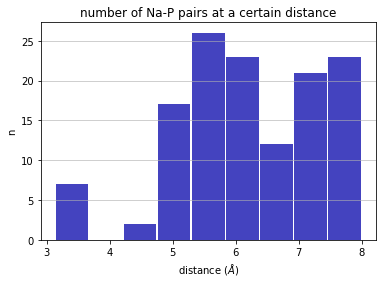

In [12]:
%matplotlib inline
n, bins, patches = plt.hist(x=distances_end, bins='auto', color='#0504aa', alpha=0.75, rwidth=0.95)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('distance ($\AA$)')
plt.ylabel('n')
plt.title(u'number of Na-P pairs at a certain distance')
plt.show()

## Ions close to phosphates - evolution

In [40]:
phosphates_all = [u.select_atoms('nucleic and name P').positions for ts in u.trajectory[:]]
sodium_all = [u.select_atoms('name NA').positions for ts in u.trajectory[:]]


In [41]:
max_cutoff = 6
ps = []
ds = []
nn = []
for ts in range(len(sodium_all)):
    p, d = dist.capped_distance(phosphates_all[ts], sodium_all[ts], max_cutoff, \
                        min_cutoff=None, box=u.dimensions, return_distances=True)
    ps.append(p)
    ds.append(d)
    nn.append(len(d))

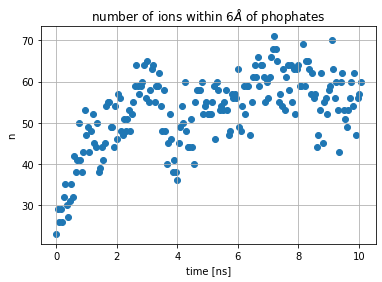

In [42]:
%matplotlib inline
plt.scatter(t_ns, nn)
plt.xlabel('time [ns]')
plt.ylabel('n')
plt.title(f'number of ions within {max_cutoff}$\AA$ of phophates')
plt.grid()
plt.show()

In [16]:
max_cutoff = 8
ps2 = []
ds2 = []
nn2 = []
for ts in range(len(sodium_all)):
    p, d = dist.capped_distance(phosphates_all[ts], sodium_all[ts], max_cutoff, \
                        min_cutoff=None, box=u.dimensions, return_distances=True)
    ps2.append(p)
    ds2.append(d)
    nn2.append(len(d))

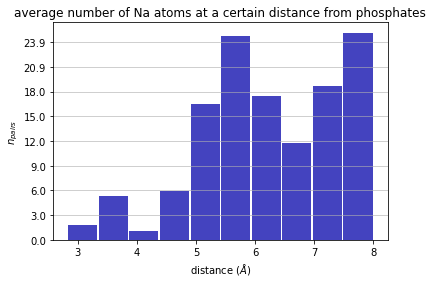

In [17]:
ds_eq = ds2[len(ds)//3*2:-1] # distances in the last third of the trajectory

%matplotlib inline
nbins = int(max_cutoff - min(np.concatenate(ds_eq))) * 2
n, bins, patches = plt.hist(x=np.concatenate(ds_eq), bins=nbins, color='#0504aa', alpha=0.75, rwidth=0.95)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('distance ($\AA$)')
plt.ylabel('$n_{pairs}$')
plt.title(u'average number of Na atoms at a certain distance from phosphates')
def div_hist(x, *args): # rescales the y-axis
    x = float(x)/len(ds_eq) + 4.9e-2
    return "{:.1f}".format(x)    
ax = plt.gca()       
ax.yaxis.set_major_formatter(mtick.FuncFormatter(div_hist))
plt.show()

(MDAnalysis.lib.correlations.autocorrelation)

In [18]:
u.trajectory[nframes-1:nframes]

## Production Run

In [45]:
## import full trajectory data 
trajdir = '../data/04-prod/'
TRR = trajdir + 'cas9_prod0.trr'
TRR2 = trajdir + 'cas9_prod1.trr'

## universe creation
u_p = mda.Universe(str(GRO), str(TRR), str(TRR2))
#u_new = u.copy() # used as a reference in memory for mapping calculations
#ref0 = mda.Universe(str(GRO))
print(u_p.select_atoms("protein or name MG").n_atoms, 'nonwater/ions atoms')

# other info
box = u_p.dimensions
print('box dimensions:', box)
nframes = u_p.trajectory.n_frames
print(nframes, 'frames')
dt = u_p.trajectory.dt # ns per frame, equal to nstxout*0.002
time_p = np.arange(0, dt*nframes, dt)
t_ns_p = time_p / 1000
print(t_ns_p[-1], 'ns')


22526 nonwater/ions atoms
box dimensions: [183.38486  183.38486  183.38478   60.000008  60.000008  90.      ]
202 frames
10.05 ns


In [46]:
phosphates_all_p = [u_p.select_atoms('nucleic and name P').positions for ts in u_p.trajectory[:]]
sodium_all_p = [u_p.select_atoms('name NA').positions for ts in u_p.trajectory[:]]

max_cutoff = 6
ps_p = []
ds_p = []
nn_p = []
for ts in range(len(sodium_all)):
    p, d = dist.capped_distance(phosphates_all_p[ts], sodium_all_p[ts], max_cutoff, \
                        min_cutoff=None, box=u_p.dimensions, return_distances=True)
    ps_p.append(p)
    ds_p.append(d)
    nn_p.append(len(d))

<IPython.core.display.Javascript object>


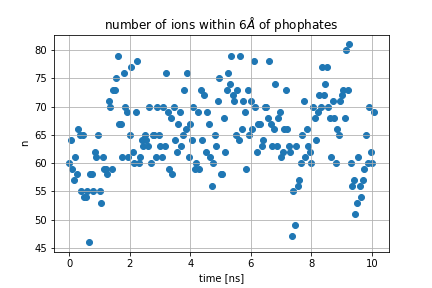

In [47]:
%matplotlib notebook
plt.scatter(t_ns_p, nn_p)
plt.xlabel('time [ns]')
plt.ylabel('n')
plt.title(f'number of ions within {max_cutoff}$\AA$ of phophates')
plt.grid()
plt.show()


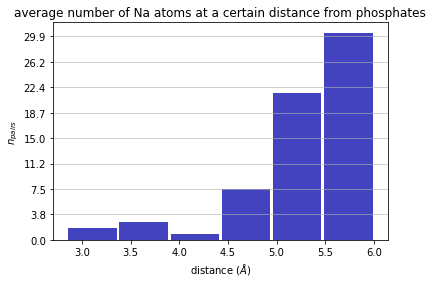

In [48]:
ds_eq = ds_p[len(ds_p)//3*2:-1] # distances in the last third of the trajectory

%matplotlib inline
nbins = int(max_cutoff - min(np.concatenate(ds_eq))) * 2
n, bins, patches = plt.hist(x=np.concatenate(ds_eq), bins=nbins, color='#0504aa', alpha=0.75, rwidth=0.95)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('distance ($\AA$)')
plt.ylabel('$n_{pairs}$')
plt.title(u'average number of Na atoms at a certain distance from phosphates')
def div_hist(x, *args): # rescales the y-axis
    x = float(x)/len(ds_eq) + 4.9e-2
    return "{:.1f}".format(x)    
ax = plt.gca()       
ax.yaxis.set_major_formatter(mtick.FuncFormatter(div_hist))
plt.show()